# Gaussian Process Option Pricing under Heston Model

## Prepare training samples for GP

### Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import qmc
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from scipy.interpolate import griddata

# Parameters
M = 1000 # Num of simulations in MC
dt = 0.01
r = 0.05
kappa = 1.0
theta = 0.2
eta = 0.5
rho = -0.4
T = 1.0
K = 100.0

# Sampling parameter
l_bound = [0,0.05] # Lower bounds for stock price and volatility
u_bound = [300,0.6] # Upper bounds for stock price and volatility

### Monte Carlo

In [2]:
# Put option payoff discounted
def put_payoff(r,T,K,S):
    # Terminal stock price
    S_T = S[-1]
    return np.exp(-r * T) * np.maximum(K - S_T,0)

In [3]:
# This function prepares 1000 samples for GP regression by Monte Carlo
def gen_train_sample(M,dt,T,K,r,kappa,theta,eta,rho,l_bound,u_bound):
    # Build 2D Halton sequence and scale it
    Halton_size = 1000
    sampler = qmc.Halton(d = 2)
    sample = sampler.random(n = Halton_size)
    scaled_sample = qmc.scale(sample,l_bound,u_bound)
    
    # Add boundary training samples
    # When stock price reaches boundary, do the simulation for 10 extra V0
    extra_size = 10
    extra_V = np.reshape(np.linspace(l_bound[1],u_bound[1],extra_size),(extra_size,1))
    col_one = np.reshape(np.ones(extra_size),(extra_size,1))
    lbc = np.hstack((l_bound[0] * col_one,extra_V))
    rbc = np.hstack((u_bound[0] * col_one,extra_V))
    stock_bc = np.vstack((lbc,rbc))
    
    # When volatility reaches boundary, do the simulation for 10 extra S0
    extra_S = np.reshape(np.linspace(l_bound[0],u_bound[0],extra_size),(extra_size,1))
    lbc = np.hstack((extra_S,l_bound[1] * col_one))
    rbc = np.hstack((extra_S,u_bound[1] * col_one))
    volat_bc = np.vstack((lbc,rbc))
    
    # Stack all those together
    SVpair = np.vstack((scaled_sample,stock_bc,volat_bc))
    
    # Return the train_sample list, it's a list of tuples
    # First component for S0, second component for V0, third component for put price
    train_sample = list()
    
    # For each (S0,V0) pair, do the Monte Carlo
    for S0, V0 in SVpair:
    
        # Store put price samples with list
        put_est = 0
        
        # N * dt = T
        N = int(np.round(T / dt))
    
        for _ in range(M):
            # Each Monte Carlo iteration
            # Build up increments of W^0,W^2
            W_0_incr = np.sqrt(dt) * np.random.randn(N + 1)
            W_2_incr = np.sqrt(dt) * np.random.randn(N + 1)
        
            # Build up increments of W^1
            W_1_incr = rho * W_2_incr + np.sqrt(1 - rho ** 2) * W_0_incr
        
            # Simulation
            S = np.zeros(N + 1)
            V = np.zeros(N + 1)
            S[0] = S0
            V[0] = V0
        
            for i in range(1,N + 1):
                # Euler scheme
                S[i] = S[i - 1] * (1 + r * dt + np.sqrt(V[i - 1]) * W_1_incr[i - 1])
            
                # Milstein scheme
                V[i] = np.maximum(V[i - 1] + kappa * (theta - V[i - 1]) * dt + \
                                  eta * np.sqrt(V[i - 1]) * W_2_incr[i - 1]
                              + (eta ** 2) / 2 * (W_2_incr[i - 1] ** 2 - dt) / 2,0)
  
            # Take average as estimate of put price (discounted)
            put_est = put_est + put_payoff(r,T,K,S) / M
            
        # Record it as training sample
        train_sample.append([S0,V0,put_est])
        
    return train_sample

## Get training samples

In [4]:
train_sample = gen_train_sample(M,dt,T,K,r,kappa,theta,eta,rho,l_bound,u_bound)
train_sample = np.array(train_sample)

### Plot training sample

<Figure size 432x288 with 0 Axes>

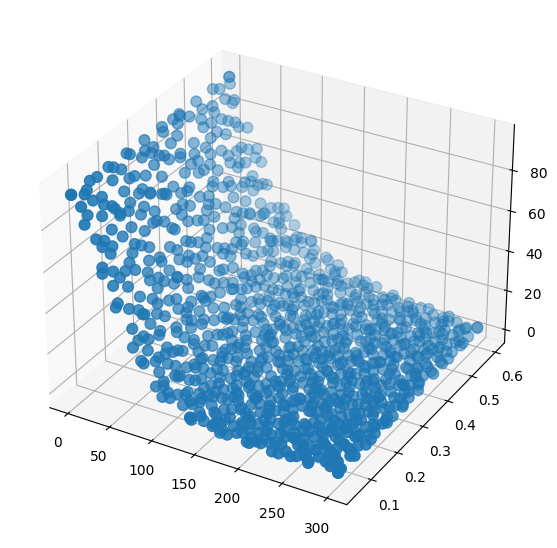

In [5]:
# 3D scatter plot on training sample
fig = plt.figure()
fig = plt.figure(figsize=(11,7), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(projection='3d')
plot_S = train_sample[:,0]
plot_V = train_sample[:,1]
ax.scatter(plot_S, plot_V, train_sample[:,2], s = 60)

## GP regression for squared exponential kernel

In [6]:
# Record the mean and stddev of the option price
opt_price_mean = np.mean(train_sample[:,2])
opt_price_stddev = np.std(train_sample[:,2])

# Split into two parts
features = train_sample[:,0:2]
opt_price = train_sample[:,2]

# Standardize option price
std_opt_price = (opt_price - opt_price_mean) / opt_price_stddev

In [7]:
# Specify the kernel with fixed lengthscale
my_kernel_exp = (10 ** 2) * RBF([10.0, 0.1],length_scale_bounds = 'fixed')
gpr = GaussianProcessRegressor(kernel = my_kernel_exp)
gpr.fit(features,std_opt_price)

/Users/a24395/Library/Python/3.8/lib/python/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=10**2 * RBF(length_scale=[10, 0.1]))

In [8]:
# Prediction made on training set
std_opt_price_pred = gpr.predict([[100,0.25]])[0]
opt_price_pred = std_opt_price_pred * opt_price_stddev + opt_price_mean
print('When S0 is 100, V0 is 0.25, put price is ' + str(opt_price_pred))

When S0 is 100, V0 is 0.25, put price is 14.480711116521618


## Make surface plot

In [9]:
# Make surfact plots based on the GP model
def make_surface_plot(l_bound,u_bound,opt_price_mean,opt_price_stddev,gpr):

    # Make surface plot
    plot_S = np.linspace(l_bound[0],u_bound[0],100)
    plot_V = np.linspace(l_bound[1],u_bound[1],100)
    plot_S, plot_V = np.meshgrid(plot_S, plot_V)
    fig = plt.figure()
    fig = plt.figure(figsize=(11,7), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection='3d')

    # Predict the values and recover from standardization
    my_feature = list()
    for i in range(100):
        for j in range(100):
            # Append the standardized features
            fea_vec = np.array([plot_S[i,j],plot_V[i,j]])
            my_feature.append(fea_vec)
    my_feature = np.array(my_feature)
    my_std_opt_price_pred = gpr.predict(my_feature)
    my_opt_price_pred = my_std_opt_price_pred * opt_price_stddev + opt_price_mean
    my_opt_price_pred = np.reshape(my_opt_price_pred,(100,100))

    # Plot
    ax.plot_surface(plot_S,plot_V,my_opt_price_pred)

<Figure size 432x288 with 0 Axes>

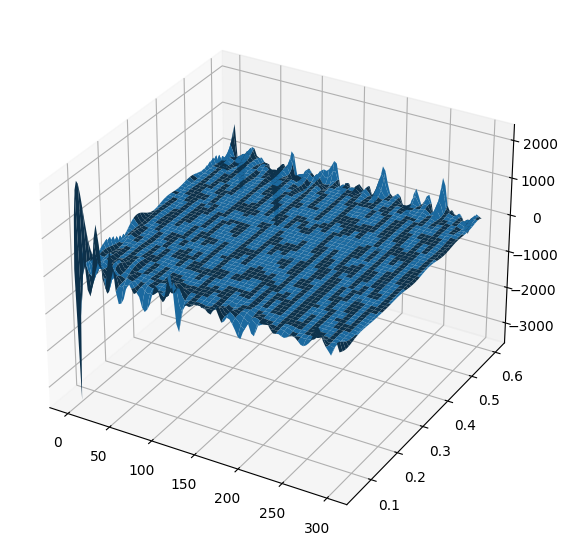

In [10]:
# Make the plot for such GP regression
make_surface_plot(l_bound,u_bound,opt_price_mean,opt_price_stddev,gpr)

## GP regression for squared exponential kernel with a different parameter

In [11]:
# Specify the kernel with fixed lengthscale, but now increase the second lengthscale
my_kernel_exp = (10 ** 2) * RBF([10.0, 1.0],length_scale_bounds = 'fixed')
gpr = GaussianProcessRegressor(kernel = my_kernel_exp)
gpr.fit(features,std_opt_price)

GaussianProcessRegressor(kernel=10**2 * RBF(length_scale=[10, 1]))

In [12]:
# Prediction made on training set
std_opt_price_pred = gpr.predict([[100,0.25]])[0]
opt_price_pred = std_opt_price_pred * opt_price_stddev + opt_price_mean
print('When S0 is 100, V0 is 0.25, put price is ' + str(opt_price_pred))

When S0 is 100, V0 is 0.25, put price is 15.368788135473704


<Figure size 432x288 with 0 Axes>

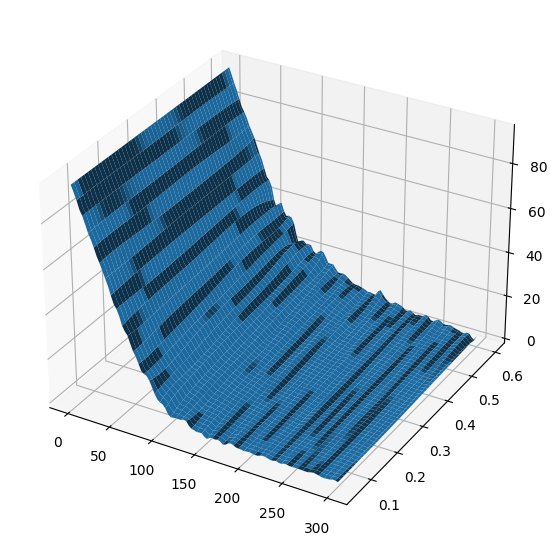

In [13]:
# Make the plot for such GP regression
make_surface_plot(l_bound,u_bound,opt_price_mean,opt_price_stddev,gpr)

## Matern kernel with optimized lengthscale parameter

In [14]:
# Specify the kernel with non-fixed lengthscale
my_kernel_matern = Matern(nu = 2.5)
gpr = GaussianProcessRegressor(kernel = my_kernel_matern)
gpr.fit(features,std_opt_price)

/Users/a24395/Library/Python/3.8/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=2.5))

In [15]:
# Prediction made on training set
std_opt_price_pred = gpr.predict([[100,0.25]])[0]
opt_price_pred = std_opt_price_pred * opt_price_stddev + opt_price_mean
print('When S0 is 100, V0 is 0.25, put price is ' + str(opt_price_pred))

When S0 is 100, V0 is 0.25, put price is 15.087405598087605


<Figure size 432x288 with 0 Axes>

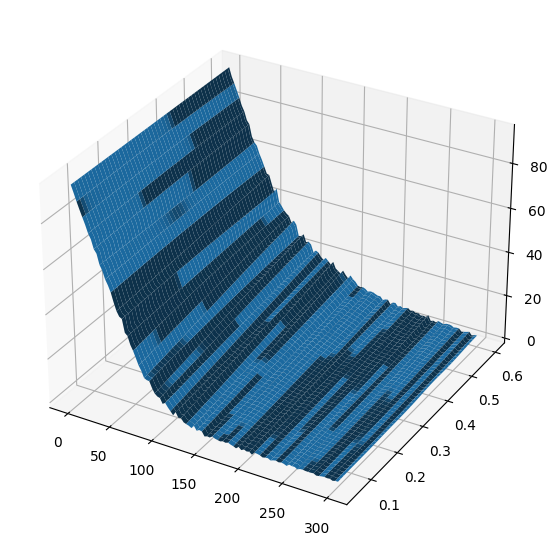

In [16]:
# Make the plot for such GP regression
make_surface_plot(l_bound,u_bound,opt_price_mean,opt_price_stddev,gpr)

## Plot the linearly interpolated surface from explicit FD scheme

I just pasted the code for problem 2 here since importing notebook causes a lot of trouble.

In [17]:
# Numerical solution parameters
smin = 0.0
smax = 300.0
vmin = 0.0
vmax = 2.0

In [18]:
# Return a matrix as the terminal condition at time T
# Has to know ds and dv for the size of the matrix
def set_call_payoff(smin,smax,ds,vmin,vmax,dv,K):
    N = int(np.round((smax - smin) / ds))
    J = int(np.round((vmax - vmin) / dv))
    stk_price = np.linspace(smin,smax,N + 1)
    terminal_vec = np.maximum(stk_price - K,0)
    # Broadcast the vector to a matrix
    terminal_mat = np.tile(np.reshape(terminal_vec,(N + 1,1)),(1,J + 1))
    return terminal_mat

In [19]:
# Input n,j and output a_{n;j}
def set_a_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return 1 - (dt / dv) * (r * dv + (n ** 2) * j * (dv ** 2) + (eta ** 2) * j)

# Input n,j and output b_{n;j}
def set_b_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt / 2) * ((n * r) + (n ** 2) * j * dv)
    
# Input n,j and output c_{n;j}
def set_c_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt / 2) * (-(n * r) + (n ** 2) * j * dv)

# Input n,j and output d_{n;j}
def set_d_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt / (2 * dv)) * ( kappa * (theta - j * dv) + (eta ** 2) * j)

# Input n,j and output e_{n;j}
def set_e_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt / (2 * dv)) * (-kappa * (theta - j * dv) + (eta ** 2) * j)

# Input n,j and output f_{n;j}
def set_f_FD(n,j,dt,dv,r,eta,theta,kappa,rho):
    return (dt * eta * j * n * rho) / 4

In [20]:
def explicit_FD_Heston(dt,ds,dv,T,smin,smax,vmin,vmax,r,kappa,theta,eta,rho,K):
    # Get size of matrix
    tmin = 0
    tmax = T
    M = int(np.round((tmax - tmin) / dt))
    N = int(np.round((smax - smin) / ds))
    J = int(np.round((vmax - vmin) / dv))
    
    # Only maintain two matrices of size (N + 1) * (J + 1) to record the numerical 
    # solution at all space variables
    # at the current time and the last time
    last_sol = set_call_payoff(smin,smax,ds,vmin,vmax,dv,K)
    sol = last_sol.copy()
    
    for m in range(M,0,-1):
        # Time index is m so derive C^{m-1} based on C^m
        # We have to derive C^{m-1}_{n;j} for all possible (n,j)
        
        # The first thing to do is to record the solution at the last time in last_sol
        # and we only update sol
        last_sol = sol
        for n in range(0,N + 1):
            # Stock price index
            for j in range(0,J + 1):
                # Volatility index
                
                # Check whether it hits boundary
                if n == 0:
                    sol[n,j] = 0
                    continue
                if n == N:
                    sol[n,j] = sol[n - 1,j] + ds
                    continue
                if j == 0:
                    sol[n,j] = (1 - r * dt) * last_sol[n,0]
                    continue
                if j == J:
                    sol[n,j] = n * ds
                    continue
                
                # Otherwise, get all coefficients
                a_FD = set_a_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                b_FD = set_b_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                c_FD = set_c_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                d_FD = set_d_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                e_FD = set_e_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                f_FD = set_f_FD(n,j,dt,dv,r,eta,theta,kappa,rho)
                
                # Perform update
                sol[n,j] = a_FD * last_sol[n,j] + b_FD * last_sol[n + 1,j] + \
                c_FD * last_sol[n - 1,j] + d_FD * last_sol[n,j + 1] + \
                e_FD * last_sol[n,j - 1]\
                + f_FD * (last_sol[n + 1,j + 1] + last_sol[n - 1,j - 1] - \
                          last_sol[n + 1,j - 1] - last_sol[n - 1,j + 1])
        if m % 1000 == 0:
            print(str(M - m) + ' iterations done.')
    return sol

In [21]:
dt_FD = 0.00005
ds = 2.5
dv = 0.1

# Do explicit finite difference scheme
call_price = explicit_FD_Heston(dt_FD,ds,dv,T,smin,smax,vmin,vmax,r,kappa,
                                theta,eta,rho,K)

# Put call parity
put_price = np.zeros(call_price.shape)
N = int(np.round((smax - smin) / ds))
J = int(np.round((vmax - vmin) / dv))
for n in range(N + 1):
    for j in range(J + 1): 
        put_price[n,j] = call_price[n,j] - n * ds + K * np.exp(-r * T)

0 iterations done.
1000 iterations done.
2000 iterations done.
3000 iterations done.
4000 iterations done.
5000 iterations done.
6000 iterations done.
7000 iterations done.
8000 iterations done.
9000 iterations done.
10000 iterations done.
11000 iterations done.
12000 iterations done.
13000 iterations done.
14000 iterations done.
15000 iterations done.
16000 iterations done.
17000 iterations done.
18000 iterations done.
19000 iterations done.


### Make plot

<Figure size 432x288 with 0 Axes>

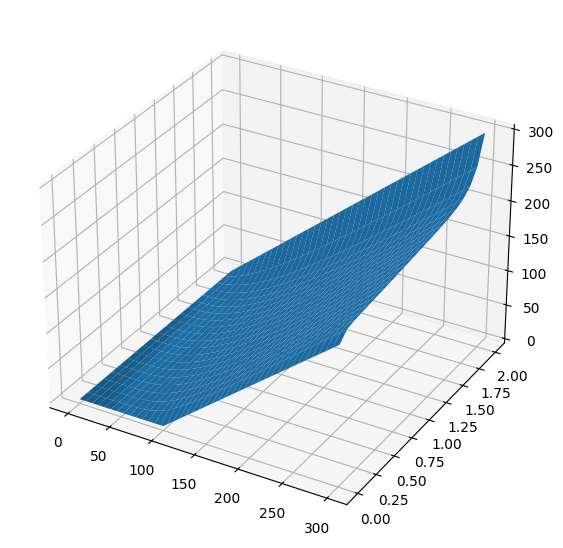

In [22]:
# Make surface plot
plot_S = np.linspace(smin,smax,N + 1)
plot_V = np.linspace(vmin,vmax,J + 1)
plot_S, plot_V = np.meshgrid(plot_S, plot_V)
fig = plt.figure()
fig = plt.figure(figsize=(11,7), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')

# Plot call price
ax.plot_surface(plot_S,plot_V,call_price.transpose())

<Figure size 432x288 with 0 Axes>

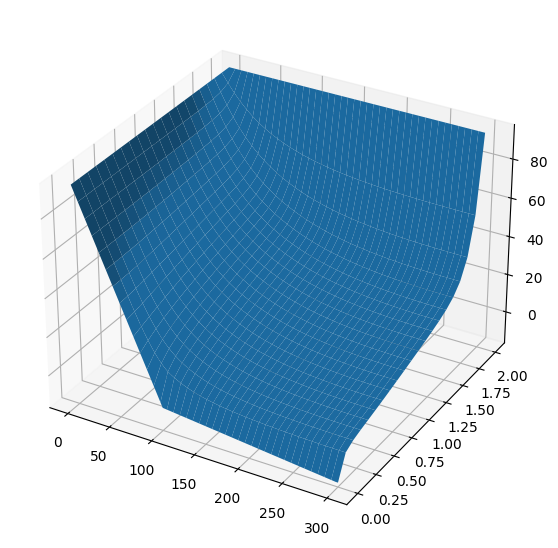

In [23]:
# Plot put price
fig = plt.figure()
fig = plt.figure(figsize=(11,7), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(plot_S,plot_V,put_price.transpose())

## Plot in the same range of axis as above to compare

<Figure size 432x288 with 0 Axes>

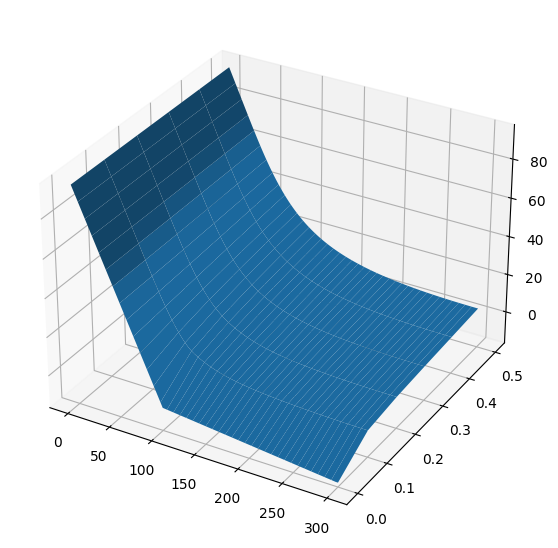

In [24]:
# Plot put price
plot_S = np.linspace(smin,smax,N + 1)
plot_V = np.linspace(vmin,vmax,J + 1)
V_ind_max = int(np.round((0.6 - vmin) / dv))
plot_V = plot_V[0:V_ind_max]
plot_S, plot_V = np.meshgrid(plot_S, plot_V)
fig = plt.figure()
fig = plt.figure(figsize=(11,7), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')

# Plot call price
ax.plot_surface(plot_S,plot_V,put_price[:,0:V_ind_max].transpose())